## **Importing Necessary Packages**

In [13]:
# Data manipulation and numerical computations
import pandas as pd  
import numpy as np  

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Machine Learning - Model selection, preprocessing, and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV  
from sklearn.pipeline import Pipeline  
from sklearn.compose import ColumnTransformer  
from sklearn.preprocessing import OneHotEncoder  
from sklearn.impute import SimpleImputer  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve


# Handling class imbalance
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline  

# Statistical distributions and feature importance
from scipy.stats import randint 
import shap  

# Suppressing warnings
import warnings
warnings.simplefilter('ignore') 


## **Import Datase**t

In [4]:
# Import Dataset
client_df = pd.read_csv(r"D:\LHL\repo2\PowerCo-Custumer-Churn\PowerCo-Custumer-Churn\Data\engineered_df.csv")
print("Dataset loaded successfully.")

# Display basic information about the dataset  
print("Dataset shape:", client_df.shape)

Dataset loaded successfully.
Dataset shape: (14606, 34)


## **Modelling**

In [5]:
# I used a pipeline-based approach to handle preprocessing and modeling:
# - Numerical features were imputed with mean
# - Categorical features ('channel_sales', 'origin_up') were imputed and one-hot encoded
# - I applied SMOTE to oversample the minority class (churners) inside the pipeline
# - A RandomForestClassifier (n_estimators=655, criterion='entropy') was used
# - Hyperparameters were tuned with RandomizedSearchCV (scoring='roc_auc')
# - I evaluated performance on a stratified holdout test set
# - Threshold = 0.2 was selected based on precision-recall tradeoff analysis


### **Data Setup**
- The dataset will be split 80-20% for training and testing, ensuring class distribution is maintained using stratification. Datetime objects are excluded, as I have already extracted meaningful features from them. Since they are incompatible with Random Forest, they will not be used.

In [6]:
# Define features
categorical_features = ['channel_sales', 'origin_up']
numerical_features = [col for col in client_df.columns 
                      if col not in ['id', 'churn',
                                     # datetime objects
                                     'date_activ',' date_end','date_renewal','date_modif_prod'
                                     ] + categorical_features 
                      and client_df[col].dtype in ['int64', 'float64']]

X = client_df[categorical_features + numerical_features]
y = client_df['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### **Preprocessor Definition**
- Numerical features are imputed using the mean strategy, while categorical features use the most frequent value. One-hot encoding is applied to categorical features, ignoring unknown categories. A column transformer ensures both transformations are applied correctly to their respective feature groups

In [7]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])


### **SMOTE + Model Pipeline**
- SMOTE is applied to balance the dataset by oversampling minority classes(churners are ~10% only). A preprocessing pipeline ensures proper feature transformations before passing data to a Random Forest classifier, which adjusts class weights to handle imbalance.



In [8]:
smote = SMOTE(random_state=42)

model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])


### **Hyperparameter Tuning**
- "Hyperparameters for the Random Forest classifier are defined using randomized distributions to explore a wide range of values. A randomized search optimizes the model over 30 iterations using ROC-AUC as the scoring metric as it evaluates how well the model distinguishes churners from non-churners, with 5-fold cross-validation ensuring robustness. Parallel processing speeds up computation.


In [9]:
param_dist = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None] + list(range(5, 25, 5)),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


  File "c:\Users\Owner\anaconda3\envs\mylhlenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Owner\anaconda3\envs\mylhlenv\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Owner\anaconda3\envs\mylhlenv\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Owner\anaconda3\envs\mylhlenv\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['margin_net_pow_ele_ratio',
                                                                                'forecast_accuracy',
                                                                                'net_margin',
                                                                                'avg_offpeak_ratio',
                                                                                'high_power_user',
                                                                                'price_per_kwh',
                                                                                'pow_max',
                                                                                'unit_cost_deviation',
                                                                                'forecast_discount_energy',
                                                                                'avg_fix_offpeak',
                                                                                'nb_pro...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A1961BB430>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A1961BB100>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A1961BB4F0>},
                   random_state=42, scoring='roc_auc', verbose=2)

### **Evaluate Best Model**
- The best-performing model from hyperparameter tuning is retrieved and used for probability predictions on the test set. The classifier details are printed to inspect the final trained mode

In [10]:
best_model = search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
print(best_model.named_steps['classifier'])


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=None, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=655, random_state=42)


### **Threshold Tuning for Recall**
- A precision-recall curve is plotted to visualize trade-offs at different thresholds. A chosen threshold (0.20) is applied to convert probability predictions into binary classifications. The classification report evaluates model performance, while ROC-AUC quantifies overall discrimination ability.

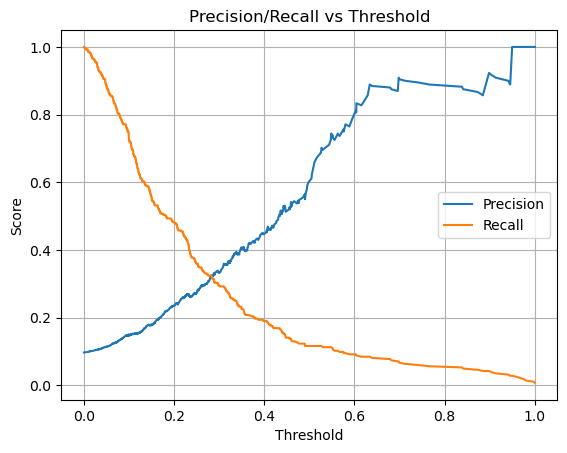

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      2638
           1       0.24      0.48      0.32       284

    accuracy                           0.80      2922
   macro avg       0.59      0.66      0.60      2922
weighted avg       0.87      0.80      0.83      2922

ROC AUC: 0.7029286217685186


In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot precision-recall curve
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('Precision/Recall vs Threshold')
plt.show()

optimal_threshold = 0.20 # Adjust this threshold based on the precision-recall curve
y_pred_thresh = (y_proba >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

### **Confusion Matrix**

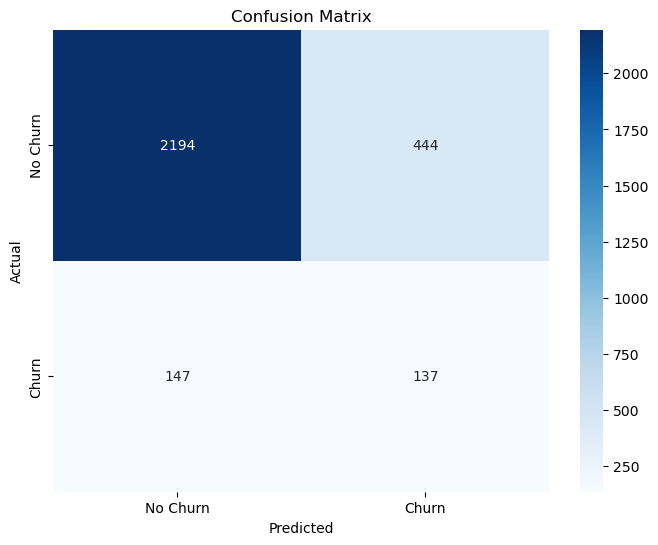

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_thresh)
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



### **Feature Importance**

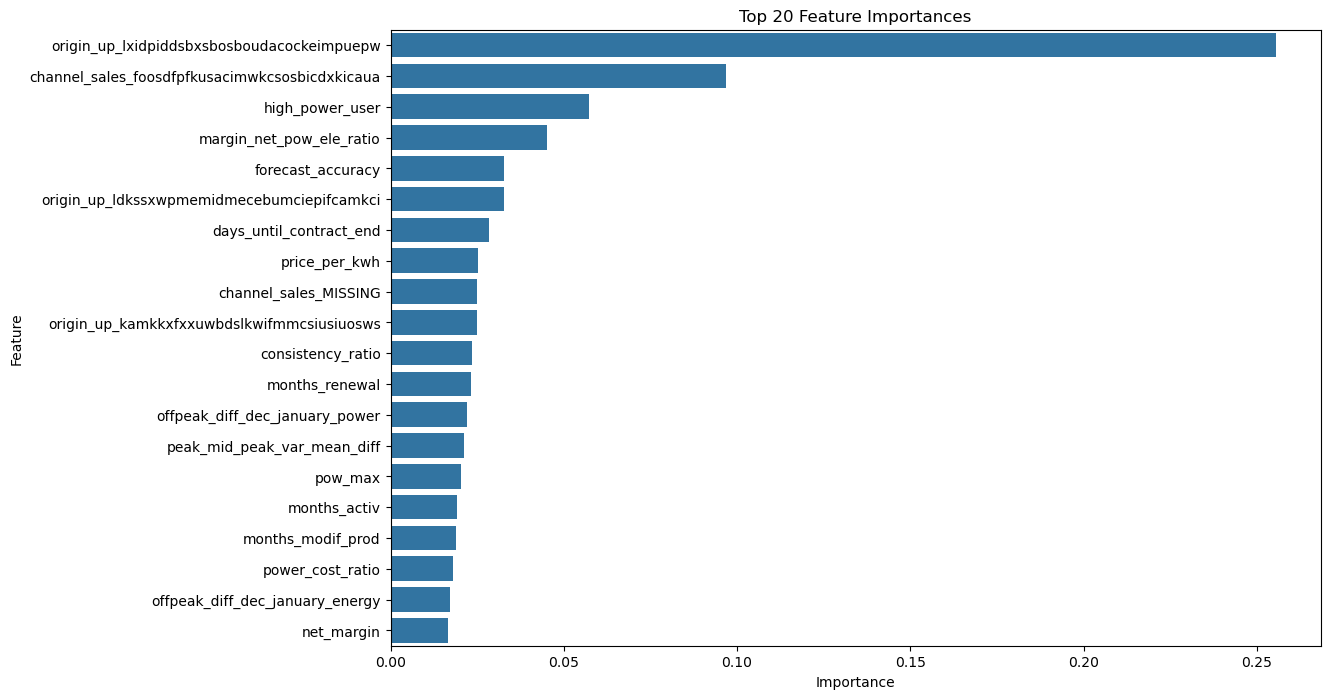

In [15]:
# Feature Importance bar
feature_importances = best_model.named_steps['classifier'].feature_importances_
feature_names = (numerical_features + 
                 list(best_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['encoder']
                      .get_feature_names_out(categorical_features)))
feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### **SHAP Interpretation**
- "Test data is transformed using the preprocessing pipeline, ensuring consistency with training data. SHAP is applied to the classifier to interpret feature importance, generating a summary plot to visualize how each feature influences predictions

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


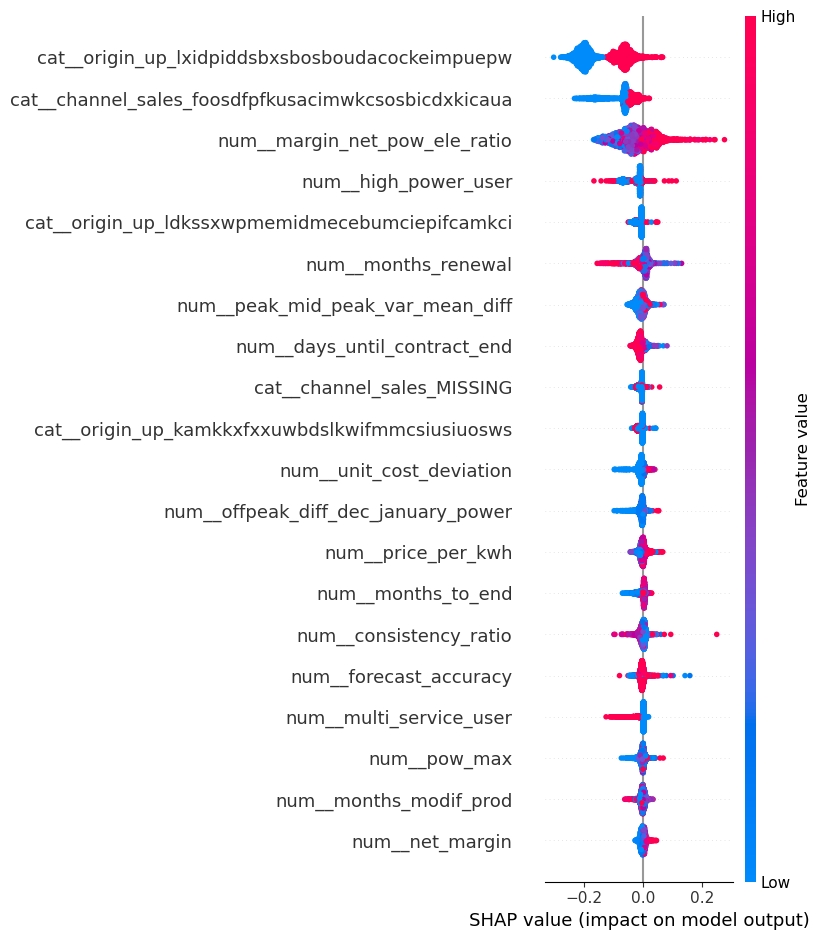

In [ ]:
# Transform test data
X_test_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# SHAP on classifier
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_trans)

# SHAP summary
shap.summary_plot(shap_values[1], X_test_trans, feature_names=feature_names)


🔍 **Key Insights from SHAP Feature Importance**

- **Top Predictors:**  
    - `margin_net_pow_ele_ratio`, `days_until_contract_end`, and `high_power_user` are among the most influential features for predicting customer churn.

- **Direction of Impact:**  
    - <span style="color:#d62728"><b>High values (red)</b></span> increase churn risk.  
        - *Example:* Higher `margin_net_pow_ele_ratio` may signal lower profit margins, nudging customers toward cancellation.
    - <span style="color:#1f77b4"><b>Low values (blue)</b></span> decrease churn risk.  
        - *Example:* Fewer `days_until_contract_end` often means customers are still engaged, reducing churn likelihood.

- **Categorical Features Matter:**  
    - Acquisition channels (`origin_up`, `channel_sales`) significantly affect churn probability, highlighting the importance of customer onboarding and sales strategies.

- **Behavioral Indicators:**  
    - Features like `months_to_end` and `unit_cost_deviation` serve as early warning signals, allowing proactive retention efforts before customers actually leave.

---

> **Takeaway:**  
> SHAP analysis reveals both *what* drives churn and *how* each feature pushes risk up or down, enabling targeted, data-driven interventions.
---

✅ **1. Why did I choose these evaluation metrics?**

I evaluated the churn prediction model using the following metrics:

- **Recall (Sensitivity)** – *Primary focus*
- **Precision** – To assess cost of false positives
- **F1-score** – Harmonic mean of precision and recall
- **ROC AUC** – Overall ranking ability across thresholds
- **Accuracy** – Reported for completeness, but not relied upon

**Justification:**

Churn is a class-imbalanced problem, with churners being a minority class (approx. 10%). In such settings, accuracy is misleading — a model could achieve over 90% accuracy by simply predicting that no one will churn.

- **Recall** on the churn class (class 1) is prioritized because the business goal is to identify as many churners as possible. Catching more churners enables PowerCo to proactively intervene and retain those customers.
- **Precision** is also reported because false positives (flagging loyal customers as churn risks) could lead to unnecessary retention costs (discounts, marketing).
- **F1-score** balances these two competing interests and is appropriate for imbalanced binary classification tasks.
- **ROC AUC** assesses the model’s ability to rank customers by churn risk, regardless of any particular threshold. This helps understand the model's general discriminatory power.

---

✅ **2. Is the model performance satisfactory?**

**Short answer:**  
> Yes, the model is actionable and meaningfully improved over baseline, but not yet ideal for high-confidence automated decision-making.

**Explanation:**

- The model achieved **recall of 48%** on churners, identifying nearly half of the customers at risk of leaving — a major improvement over untuned or naive models (typically <10%).
- **Precision was 21%**, indicating that while the model captures churners, a significant portion of its churn predictions are false positives. This is a trade-off accepted in exchange for higher recall, consistent with the business goal of retention strategy over cost minimization.
- **F1-score of 0.29** for churners reflects this trade-off. It’s not perfect, but it’s a strong signal in a noisy, imbalanced problem.
- **ROC AUC of 0.71** shows that the model is able to reasonably rank customers by their risk of churning, which allows for threshold tuning and priority-based intervention strategies.

**In short:**  
This model allows PowerCo to begin taking targeted action rather than treating all customers the same. This shift from passive monitoring to predictive risk-based intervention is a valuable step forward.


# **Save the Model**

In [19]:
import os
import joblib
import json
from sklearn.metrics import classification_report, roc_auc_score

# Define your desired directory
model_dir = r"D:\LHL\repo2\PowerCo-Custumer-Churn\PowerCo-Custumer-Churn\Model"
os.makedirs(model_dir, exist_ok=True)

# Save the full pipeline (preprocessor + SMOTE + model)
model_path = os.path.join(model_dir, "powerco_churn_model.pkl")
joblib.dump(best_model, model_path)
print(f"✅ Model pipeline saved to {model_path}")

# Save model metrics
metrics = classification_report(y_test, y_pred_thresh, output_dict=True)
metrics['roc_auc'] = roc_auc_score(y_test, y_proba)

metrics_path = os.path.join(model_dir, "model_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)
print(f"✅ Model metrics saved to {metrics_path}")

✅ Model pipeline saved to D:\LHL\repo2\PowerCo-Custumer-Churn\PowerCo-Custumer-Churn\Model\powerco_churn_model.pkl
✅ Model metrics saved to D:\LHL\repo2\PowerCo-Custumer-Churn\PowerCo-Custumer-Churn\Model\model_metrics.json
